In [1]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm_notebook
import pandas as pd
from keras.utils import np_utils
from sklearn.cluster import KMeans
import csv
import math
import matplotlib.pyplot
from matplotlib import pyplot as plt

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
TrainingPercent = 80
ValidationPercent = 10
TestPercent = 10
#M is the number of basis functions
M = 10
PHI = []

# Reading data from Human observed same pair and different pair csv


In [3]:
def GetHumanObservedFeatureData():
    humanSamePair = pd.read_csv('HumanObserved-Dataset/HumanObserved-Features-Data/same_pairs.csv') 
    humanDiffPair = pd.read_csv('HumanObserved-Dataset/HumanObserved-Features-Data/diffn_pairs.csv')
    #Reading human observed feature data csv 
    humanFeatureData = pd.read_csv('HumanObserved-Dataset/HumanObserved-Features-Data/HumanObserved-Features-Data.csv')
    #print(humanFeatureData.img_id)
    #print(humanSamePair.img_id_A, humanSamePair.img_id_B) 

    sameFeatureMerge=pd.merge(humanSamePair, humanFeatureData,  how='inner', left_on=['img_id_A'], right_on = ['img_id'], suffixes= ['_A','_A'])
    featureListSame=pd.merge(sameFeatureMerge, humanFeatureData, how='inner', left_on=['img_id_B'], right_on = ['img_id'], suffixes= ['_A','_B'])
    #print(featureListSame)

    diffFeatureMerge=pd.merge(humanDiffPair, humanFeatureData,  how='inner', left_on=['img_id_A'], right_on = ['img_id'], suffixes= ['_A','_A'])
    featureListDiff=pd.merge(diffFeatureMerge, humanFeatureData, how='inner', left_on=['img_id_B'], right_on = ['img_id'], suffixes= ['_A','_B'])
    return sameFeatureMerge, featureListSame, diffFeatureMerge, featureListDiff
    #print(featureListDiff.iloc[2])

In [4]:
sameFeatureMerge, featureListSame, diffFeatureMerge, featureListDiff = GetHumanObservedFeatureData()
#Getting the array vector of Target values from 'same_pairs.csv'.
def ProcessData(featureListSame,featureListDiff):
    t1 = []
    t1_target=[]
    t2_target=[]
    #t1 =np.array(featureListSame.iloc[0:791,[2,5,6,7,8,9,10,11,12,13,16,17,18,19,20,21,22,23,24]].values)
    #t2 = np.array(featureListDiff.iloc[0:791,[2,5,6,7,8,9,10,11,12,13,16,17,18,19,20,21,22,23,24]].values)
    #t1=np.concatenate((t2,t1))
    col=[2]
    col1=[5,6,7,8,9,10,11,12,13]
    col2=[16,17,18,19,20,21,22,23,24]
    t1 =np.array(featureListSame.iloc[0:791,col1].values)
    t2 =np.array(featureListDiff.iloc[0:791,col2].values)
    t1=np.subtract(t1,t2)
    t1=np.insert(t1, 5, values=col, axis=1)
    np.random.shuffle(t1)
    print(t1)
    return t1
t1 = ProcessData(featureListSame,featureListDiff)
print(t1.shape)

[[ 2  0  0 ... -1 -2  0]
 [-2 -1  0 ... -1 -2  0]
 [ 0  0  0 ...  1 -2 -1]
 ...
 [-1  0  0 ... -1 -1  0]
 [ 1 -1  0 ...  3  0  0]
 [ 2  0  0 ...  0  3  0]]
(791, 10)


In [5]:
#Getting the matrix of total data
def GenerateRawData(t1):    
    dataMatrix = [] 
    
    dataMatrix = np.transpose(t1)     
    print ("Data Matrix Shape.."+ str(dataMatrix.shape))
    return dataMatrix

def GenerateTrainingTarget(rawTraining,TrainingPercent = 80):
    TrainingLen = int(math.ceil(len(rawTraining)*(TrainingPercent*0.01)))
    t           = rawTraining[:TrainingLen]
    #print(str(TrainingPercent) + "% Training Target Generated..")
    return t

def GenerateTrainingDataMatrix(rawData, TrainingPercent = 80):
    T_len = int(math.ceil(rawData.shape[0]*0.01*TrainingPercent))
    print("RawData"+str(rawData.shape))
    d2 = rawData[0:T_len,:]
    #print(str(TrainingPercent) + "% Training Data Generated..")
    return d2


#Generating the list of validation target values which is 10% of total length
#List of size 10% of the total length will be obtained.
def GenerateValTargetVector(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(rawData.shape[0]*ValPercent*0.01))
    V_End = TrainingCount + valSize
    t =rawData[TrainingCount:V_End-1]
    #print (str(ValPercent) + "% Val Target Data Generated..")
    return t


GenerateRawData(t1)

Data Matrix Shape..(10, 791)


array([[ 2, -2,  0, ..., -1,  1,  2],
       [ 0, -1,  0, ...,  0, -1,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [-1, -1,  1, ..., -1,  3,  0],
       [-2, -2, -2, ..., -1,  0,  3],
       [ 0,  0, -1, ...,  0,  0,  0]])

In [6]:
def GenerateValData(rawData, ValPercent, TrainingCount): 
    #ceil() returns ceiling value of x i.e the smallest integer not less than x.
    valSize = int(math.ceil(rawData.shape[0]*ValPercent*0.01))
    V_End = TrainingCount + valSize
    dataMatrix = rawData[TrainingCount:V_End-1,:]
    print("Validation Data Matrix"+str(dataMatrix.shape))  
    return dataMatrix

In [7]:
def GenerateBigSigma(Data, MuMatrix,TrainingPercent):
    #np.zeros returns the array of given shape and type, padded with zeros.
    DataT       = np.transpose(Data)
    BigSigma    = np.zeros((len(DataT),len(DataT)))
    print("BigsigmaShape"+str(BigSigma.shape))
    print("SHAPE OF DataT---->>>>>"+str(DataT.shape))
    TrainingLen = math.ceil(DataT.shape[0]*TrainingPercent*0.01)        
    varVect     = []
    for i in range(0,len(DataT)):
        vct = []
        for j in range(0,int(TrainingLen)):
            vct.append(Data[i][j])    
        varVect.append(np.var(vct))
    
    for j in range(len(DataT)):
        BigSigma[j][j] = varVect[j]
    ##print ("BigSigma Generated..")
    return BigSigma


#In order to obtain phi we are calculating the scalar 
#Scalar needs Data,Mu and inverse of Bigsigma
def GetScalar(DataRow,MuRow, BigSigInv):
    #DataRow=np.transpose(DataRow)
    print("MUROW SHAPE :"+ str(MuRow.shape))
    print("DATAROW SHAPE : "+ str(DataRow.shape))
    R = np.subtract(DataRow,MuRow)
    T = np.dot(BigSigInv,R)  
    L = np.dot(R,T)
    return L

#We are calculating the phi of x using Radial Basis function in the below method.
def GetRadialBasisOut(DataRow,MuRow, BigSigInv):    
    phi_x = math.exp(-0.5*GetScalar(DataRow,MuRow,BigSigInv))
    return phi_x

#Below function defines the calculation of phi matrix for the closed form solution.
def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80):
    print("MuMatrix for training"+str(MuMatrix.shape))
    DataT = np.transpose(Data)
    TrainingLen = math.ceil(Data.shape[0]*TrainingPercent*0.01)         
    PHI = np.zeros((int(TrainingLen),len(MuMatrix)))
    print("PHI SHAPE for Training: "+str(PHI.shape))
    BigSigInv = np.linalg.inv(BigSigma)
    print("BigSigInv SHAPE"+ str(BigSigInv.shape))
    print("DATA: "+str(len(Data[2])))
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(TrainingLen)):
            
            PHI[R][C] = GetRadialBasisOut(Data[R], MuMatrix[C], BigSigInv)
    #print ("PHI Generated..")
    return PHI

def GetPhiMatrixForTestAndVal(Data, MuMatrix, BigSigma, TrainingPercent = 80):
    DataT = np.transpose(Data)
    TrainingLen = math.ceil(DataT.shape[0]*TrainingPercent*0.01)         
    PHI = np.zeros((int(TrainingLen),len(MuMatrix)))
    print("PHI SHAPE: "+str(PHI.shape))
    BigSigInv = np.linalg.inv(BigSigma)
    print("BigSigInv SHAPE"+ str(BigSigInv.shape))
    print("DATA: "+str(len(Data[2])))
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(TrainingLen)):
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)
    #print ("PHI Generated..")
    return PHI

#In the below method we are evaluating the validation test.
def GetValTest(VAL_PHI,W):
    print("Val PHI shape:"+str(VAL_PHI.shape))
    print("W shape:"+str(W.shape))
    Y = np.dot(VAL_PHI,W)
    #print ("Test Out Generated..")
    return Y

#In the below method, we are calculating the erms for the closed form solution.
def GetErms(VAL_TEST_OUT,ValDataAct):
    sum = 0.0
    t=0
    accuracy = 0.0
    counter = 0
    val = 0.0
    print("ValDataAct shape:"+str(ValDataAct.shape))
    print("VAL_TEST_OUT shape:"+str(VAL_TEST_OUT.shape))
    for i in range (0,len(VAL_TEST_OUT)):
        print("ValDataAct Length:",+len(ValDataAct))
        print("VAL_TEST_OUT:"+str(len(VAL_TEST_OUT)))
        sub=(ValDataAct[i] - VAL_TEST_OUT[i])
        power = sub*sub
        sum =sum+power
        valDataAct=ValDataAct[i]
        valTestOut=VAL_TEST_OUT[i]
        valTestAround=np.around(valTestOut, 0)
        print("valTestAround :"+str(valTestAround))
        valTestAroundInt=int(valTestAround)
        if(valTestAround == valDataAct):
            counter+=1
    accuracy = (float((counter*100))/float(len(VAL_TEST_OUT)))
    print ("Accuracy Generated.."+str(accuracy))
    ##print ("Validation E_RMS : " + str(math.sqrt(sum/len(VAL_TEST_OUT))))
    return (str(accuracy) + ',' +  str(math.sqrt(sum/len(VAL_TEST_OUT))))


# Fetch and Prepare Dataset

In [8]:
RawData = np.array(t1[:,1:])
RawTarget = np.array(t1[:,0:1])
print (RawData.shape)
print (RawTarget.shape)

(791, 9)
(791, 1)


# Prepare Training Data

In [9]:
TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
TrainingData= np.transpose(TrainingData)
print(TrainingTarget.shape)
print(TrainingData.shape)

RawData(791, 9)
(633, 1)
(9, 633)


# Prepare Validation Data

In [10]:
#We have used np.array for ValDataAct because it is of list type and we want
# it to be of array type
print(len(TrainingTarget))
ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget))))
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))
ValData = np.transpose(ValData)
print(ValDataAct.shape)
print(ValData.shape)

633
Validation Data Matrix(79, 9)
(79, 1)
(9, 79)


# Prepare Test Data

In [11]:
TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))
TestData = np.transpose(TestData)
print(ValDataAct.shape)
print(ValData.shape)

Validation Data Matrix(79, 9)
(79, 1)
(9, 79)


In [12]:
kmeans = KMeans(n_clusters=M, random_state=0).fit(np.transpose(TrainingData))
Mu = kmeans.cluster_centers_
BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent)
TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)
VAL_PHI      = GetPhiMatrixForTestAndVal(ValData, Mu, BigSigma, 100)
TEST_PHI     = GetPhiMatrixForTestAndVal(TestData, Mu, BigSigma, 100) 

BigsigmaShape(9, 9)
SHAPE OF DataT---->>>>>(9, 791)
MuMatrix for training(10, 9)
PHI SHAPE for Training: (633, 10)
BigSigInv SHAPE(9, 9)
DATA: 9
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9

DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MURO

DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MURO

MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW

MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW

DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MURO

DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MURO

MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW

MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW

MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW

MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW

MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW

MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW

MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW

MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW

DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MURO

MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW

MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW SHAPE : (9,)
MUROW SHAPE :(9,)
DATAROW

# Gradient Descent solution for Linear Regression

In [13]:
print ('----------------------------------------------------------------')
print ('-----Please Wait for 2 mins! Performing Gradient Descent--------')
print ('----------------------------------------------------------------')

----------------------------------------------------------------
-----Please Wait for 2 mins! Performing Gradient Descent--------
----------------------------------------------------------------


In [14]:
#W_Now is the random weight we have initialized to the data nodes in our model
#W=100
W_Now        = np.zeros((M))
print("W_NOW:"+str(W_Now.shape))
#La is the regularizer to avoid the noisy data nodes in our model and to obtain
# generalized curve.
La           = 1
learningRate = 0.5
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []

for i in range(0,100):
    
    #print ('---------Iteration: ' + str(i) + '--------------')
    #Delta_E_D is difference between the expected and observed outcomes of the model.
    print("W_Now:"+str(W_Now.shape))
    print("TrainingTarget[i]:"+str(TrainingTarget[i][0]))
    print("TRAINING_PHI[i]:"+str(TRAINING_PHI[i].shape))
    Delta_E_D     = -np.dot((TrainingTarget[i][0] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),np.transpose(TRAINING_PHI[i]))
    print("Delta_E_D:"+str(Delta_E_D.shape))
    #La_Delta_E_W is the change in weights that can be calculated by multiplying
    #the initial weight and the regularizer we have taken for our model.
    La_Delta_E_W  = np.dot(La,W_Now)
    Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    
    Delta_W       = -np.dot(learningRate,Delta_E)
    W_T_Next      = W_Now + Delta_W
    #Old weights will now be updated with the new weights.
    W_Now         = W_T_Next
    
    #-----------------TrainingData Accuracy---------------------#
    #We are testing the accuracy of outcomes of the model based on the training data set provided
    print("TRAINING_PHI shape:"+str(TRAINING_PHI.shape))
    print("W_T_Next:"+str(W_Now.shape))
    TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
    print("TR_TEST_OUT Shape:"+str(TR_TEST_OUT.shape))
    Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
    L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    
    #-----------------ValidationData Accuracy---------------------#
    #We are testing the accuracy of outcomes of the model based on the validation data set.
    VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
    Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
    L_Erms_Val.append(float(Erms_Val.split(',')[1]))
    
    #-----------------TestingData Accuracy---------------------#
    #We are testing the accuracy of outcomes of the model based on the test data set.
    TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
    Erms_Test = GetErms(TEST_OUT,TestDataAct)
    L_Erms_Test.append(float(Erms_Test.split(',')[1]))

W_NOW:(10,)
W_Now:(10,)
TrainingTarget[i]:2
TRAINING_PHI[i]:(10,)
Delta_E_D:(10,)
TRAINING_PHI shape:(633, 10)
W_T_Next:(10,)
Val PHI shape:(633, 10)
W shape:(10,)
TR_TEST_OUT Shape:(633,)
ValDataAct shape:(633, 1)
VAL_TEST_OUT shape:(633,)
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestArou

valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:6

ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_

valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633

valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
v

VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79


ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-1.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633


ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633


ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-1.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633


ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
Accuracy Generated..37.9746835443038
Val PHI shape:(79, 10)
W shape:(10,)
ValDataAct shape:(79, 1)
VAL_TEST_OUT shape:(79,)
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDat

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633


ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633


valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround 

VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
Val

valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 6

VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:7

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633


VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
Val

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633


VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
Val

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633


VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
Val

ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Len

VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
Val

valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 6

VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
Val

valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL

ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 

valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
V

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTe

valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0

VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 6

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
Accuracy Generated..32.069510268562404
Val PHI shape:(79, 10)
W shape:(10,)
ValDataAct shape:(79, 1)
VAL_TEST_OUT shape:(79,)
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Lengt

ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
Accuracy Generated..22.78481012658228
W_Now:(10,)
TrainingTarget[i]:0
TRAINING_PHI[i]:(10,)
Delta_E_D:(10,)
TRAINING_PHI shape:(633, 10)
W_T_Next:(10,)
Val PHI shape:(633, 10)
W shape:(10,)
TR_TEST_OUT Shape:(633,)
ValDataAct shape:(633, 1)
VAL_TEST_OUT shape

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0

VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length:

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :

valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OU

valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTes

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
val

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
v

VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79


ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633


ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633


ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
Accuracy Generated..32.069510268562404
Val PHI shape:(79, 10)
W shape:(10,)
ValDataAct shape:(79, 1)
VAL_TEST_OUT shape:(79,)
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:7

valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 6

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633


valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround 

VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
Val

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633


valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 6

VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
Val

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633


valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 6

VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
Val

valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VA

VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct 

valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 63

ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
Accuracy Generated..22.78481012658228
W_Now:(10,)
TrainingTarget[i]:-1
TRAINING_PHI[i]:(10,)
Delta_E_D:(10,)
TRAINING_PHI shape:(633, 10)
W_T_Next:(10,)
Val PHI shape:(633, 10)
W shape:(10,)
TR_TEST_OUT Shape:(633,)
ValDataAct shape:(633, 1)
VAL_TEST_OUT shape:(633,)
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
V

valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 63

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
va

VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:7

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround 

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround 

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround 

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround 

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0

VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 6

valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct L

VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 6

VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 6

valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct L

valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633


valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 6

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633


ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Len

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633


ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633


VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDa

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
va

valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 6

valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 6

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround

VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
Accuracy Generated..22.78481012658228
W_Now:(10,)
TrainingTarget[i]:-1
TRAINING_PHI[i]:(10,)
Delta_E_D:(10,)
TRAINING_PHI shape:(633, 10)
W_T_Next:(10,)
Val PHI shape:(633, 10)
W shape:(10,)
TR_TEST_OUT Shape:(633,)
ValDataAct shape:(633, 1)
VAL_TEST_OUT shape:(633,)
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestArou

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTest

valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633

ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAr

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-1.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-1.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-1.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-1.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633


VAL_TEST_OUT:633
valTestAround :-1.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-1.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-1.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-1.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-1.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-1.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-1.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
Val

valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 6

ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-1.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-1.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Len

valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 6

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633


ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633


VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
Val

ValDataAct shape:(79, 1)
VAL_TEST_OUT shape:(79,)
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79


valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 6

ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Len

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633


ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
v

ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Len

VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
Val

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-1.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-1.0
ValDataAct Length: 633
VAL_TEST_OUT:633


valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-1.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-1.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 6

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
va

VAL_TEST_OUT shape:(79,)
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAr

VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValD

valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 6

valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround 

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :

VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 6

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0

valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:6

ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0

ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_

VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :1.0
ValDataAct Length: 6

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :

valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:6

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :

ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST

valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:6

valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:6

valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:6

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0

valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct L

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0

valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :1.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :1.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :1.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :1.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :1.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :1.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:6

VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :1.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :1.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :1.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 6

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0

ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0

valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:6

ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_

valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:6

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-1.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-1.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
va

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-1.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
val

VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValD

ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
Accuracy Generated..22.78481012658228
W_Now:(10,)
TrainingTarget[i]:-2
TRAINING_PHI[i]:(10,)
Delta_E_D:(10,)
TRAINING_PHI shape:(633, 10)
W_T_Next:(10,)
Val PHI shape:(633, 10)
W shape:(10,)
TR_TEST_OUT Shape:(633,)
ValDataAct shape:(633, 1)
VAL_TEST_OUT shape:(633,)
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Lengt

valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 6

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633


VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Len

ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79

valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TES

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAroun

VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 6

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
Accuracy Generated..32.069510268562404
Val PHI shape:(79, 10)
W shape:(10,)
ValDataAct shape:(79, 1)
VAL_TEST_OUT shape:(79,)
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0

valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 63

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTe

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
v

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633


ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAr

ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79

VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 6

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0

valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct L

VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 6

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633


ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
Accuracy Generated..37.9746835443038
Val PHI shape:(79, 10)
W shape:(10,)
ValDataAct shape:(79, 1)
VAL_TEST_OUT shape:(79,)
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDat

VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length:

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAro

ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :-0.0
ValDataAct Length: 79
VA

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0

ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_

valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:6

ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :0

valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct Length: 79
VAL_TEST_OUT:79
valTestAround :0.0
ValDataAct L

VAL_TEST_OUT:633
valTestAround :-1.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-1.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-1.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-1.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-1.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
ValDataAct Length: 633
VAL_TEST_OUT:633
valTestAround :-0.0
Val

----------Gradient Descent Solution--------------------
E_rms Training   = 0.71363
E_rms Validation   = 0.69916
E_rms Testing   = 0.69758


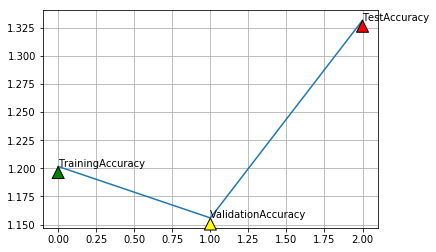

In [17]:
print ('----------Gradient Descent Solution--------------------')
print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),5)))
print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),5)))
print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))
TrainingAccuracy_flt=float(np.around(min(L_Erms_TR),5))
ValidationAccuracy_flt=float(np.around(min(L_Erms_Val),5))
TestAccuracy_flt=float(np.around(min(L_Erms_Test),5))

#In order to plot the graph
plt.plot([TrainingAccuracy_flt,ValidationAccuracy_flt,TestAccuracy_flt])
plt.annotate('TrainingAccuracy', (0,TrainingAccuracy_flt), (0,TrainingAccuracy_flt),
            arrowprops=dict(facecolor='green', shrink=0.05),
            )
plt.annotate('ValidationAccuracy', (1,ValidationAccuracy_flt), (1,ValidationAccuracy_flt),
            arrowprops=dict(facecolor='yellow', shrink=0.05),
            )
plt.annotate('TestAccuracy', (2,TestAccuracy_flt), (2,TestAccuracy_flt),
            arrowprops=dict(facecolor='red', shrink=0.01),
            )
plt.grid()
plt.show()